# 4 варіант
Полiномiальна регресiя, алгоритм Adam, MSE з регуляризацiєю за нормою L2.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman3
import optuna

EPOCHS = 100

DEGREE_2 = 2

tf.random.set_seed(17)

Оскільки у завданні потрібно виводити кожні 10 епох, то будемо використовувати кастомний колбек для виводу інформації

In [20]:
class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % 10 == 0:
            print(f'Epoch {epoch}: Loss = {logs["loss"]:.4f}, R_square = {logs["r_square"]:.4f}, MSE = {logs["mean_squared_error"]:.4f}, \
                  \n Val Loss = {logs["val_loss"]}, Val R Square = {logs["val_r_square"]}, Val MSE = {logs["val_mean_squared_error"]} \n')

# 1 датасет

In [21]:
X_data = np.linspace(-1, 1 , 100 )

num_coef = 9
coef = [1, 2, 3, 3, 5, 6, 4, 300, 2]
y_data = 0
for i in range (num_coef):
    y_data += coef[i] * np.power(X_data, i)
y_data += np.random.randn(*X_data.shape) * 10.5

Text(0, 0.5, 'y')

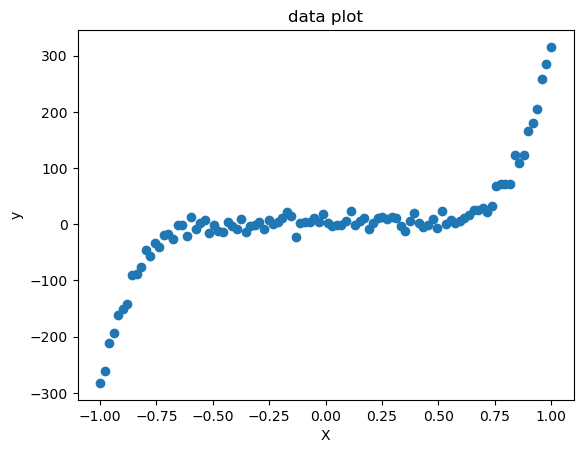

In [22]:
plt.scatter(x=X_data, y=y_data)
plt.title('data plot')
plt.xlabel('X')
plt.ylabel('y')

Як на мене ми маємо чисте кубічне рівняння

In [23]:
DEGREE_1 = 3

# Ділимо дані

Оскільки нам потім потрібно буде підбирати значення гіперпараметрів: регуляризації та швидкості навчання то розбивати будемо на 3 набори даних

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=17)

poly = PolynomialFeatures(degree=DEGREE_1)

X_train = poly.fit_transform(X_train.reshape(-1, 1))
X_train_val = poly.transform(X_train_val.reshape(-1, 1))
X_test = poly.transform(X_test.reshape(-1, 1))
X_val = poly.transform(X_val.reshape(-1, 1))
X = poly.transform(X_data.reshape(-1, 1))

stdscaler = StandardScaler()

y_train = stdscaler.fit_transform(y_train.reshape(-1, 1))
y_train_val = stdscaler.transform(y_train_val.reshape(-1, 1))
y_test = stdscaler.transform(y_test.reshape(-1, 1))
y_val = stdscaler.transform(y_val.reshape(-1, 1))
y = stdscaler.transform(y_data.reshape(-1, 1))

X_tens = tf.constant(X, dtype=tf.float32)
y_tens = tf.constant(y, dtype=tf.float32)

X_tens_train = tf.constant(X_train, dtype=tf.float32)
X_tens_train_val = tf.constant(X_train_val, dtype=tf.float32)
X_tens_test = tf.constant(X_test, dtype=tf.float32)
X_tens_val = tf.constant(X_val, dtype=tf.float32)

y_tens_train = tf.constant(y_train, dtype=tf.float32)
y_tens_train_val = tf.constant(y_train_val, dtype=tf.float32)
y_tens_test = tf.constant(y_test, dtype=tf.float32)
y_tens_val = tf.constant(y_val, dtype=tf.float32)

## Функції для Optuna з ініціалізацією моделі

Оскільки Optuna на даний момент це одна з найкращих бібліотек для оптимізацї гіперпараметрів, то використовувати будемо її

Спочатку нам потрібно вказати які гіперпараметри налаштовувати, у нашому випадку це регуляризація та швидкість навчання

Потім ми ініціалізуємо саму модель із цими гіперпараметрами, навчаємо її і функції самотужки підбирає їх значення через баєсівську оптимізацію

Також оскільки у нас йде паралельне навчання декількох моделей я виставив verbose = 0

Навчати будемо на навчальному та валідаційному наборі даних

*код для ініціалізації був взятий [тут](https://github.com/optuna/optuna-examples/blob/main/keras/keras_simple.py)*

In [25]:
def objective(trial):
    
    c_lambda_1 = trial.suggest_float("lambda_1", 1e-5, 1, log=True)
    c_lambda_2 = trial.suggest_float("lambda_2", 1e-5, 1, log=True)
    lrng_rate = trial.suggest_float("lrng_rate", 1e-5, 1, log=True)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu', input_shape=(DEGREE_1 + 1,), kernel_regularizer=tf.keras.regularizers.l2(c_lambda_1)),
        tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(c_lambda_2)),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrng_rate),
            loss='mean_squared_error',
            metrics = [tfa.metrics.RSquare(), tf.keras.metrics.MeanSquaredError()])

    model.fit(X_tens_train, y_tens_train,
                    epochs=EPOCHS,
                    verbose=0,
                    validation_data=(X_tens_val, y_tens_val))

    score = model.evaluate(X_tens_val, y_tens_val, verbose=0)
    return score[0]

In [26]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=15, timeout=600, n_jobs=-1)

[I 2023-06-02 13:07:17,481] A new study created in memory with name: no-name-cccf5cb0-f0ac-476f-bbf3-38eaf801c655
[I 2023-06-02 13:07:32,522] Trial 5 finished with value: 1.013948917388916 and parameters: {'lambda_1': 0.0004297748860820408, 'lambda_2': 0.0048655163552480075, 'lrng_rate': 8.621024499908945e-05}. Best is trial 5 with value: 1.013948917388916.
[I 2023-06-02 13:07:32,764] Trial 2 finished with value: 0.21776559948921204 and parameters: {'lambda_1': 4.6162556599450445e-05, 'lambda_2': 0.003977670377213973, 'lrng_rate': 0.0013214482571546537}. Best is trial 2 with value: 0.21776559948921204.
[I 2023-06-02 13:07:33,191] Trial 3 finished with value: 0.6341613531112671 and parameters: {'lambda_1': 0.0002058729392156492, 'lambda_2': 0.0029098995253266195, 'lrng_rate': 3.858353415761325e-05}. Best is trial 2 with value: 0.21776559948921204.
[I 2023-06-02 13:07:33,327] Trial 0 finished with value: 0.22642627358436584 and parameters: {'lambda_1': 0.017267037692059575, 'lambda_2': 0

In [27]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 15
Best trial:
  Value: 0.026922233402729034
  Params: 
    lambda_1: 0.001093657579071814
    lambda_2: 4.0195481038270954e-05
    lrng_rate: 0.0631772251274463


Тепер візьмемо найкращу модель і перенавчимо її на навчальний + валідаційний наборі даних

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(DEGREE_1 + 1,), kernel_regularizer=tf.keras.regularizers.l2(0.00004)),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01669),
              loss='mean_squared_error',
              metrics=[tfa.metrics.RSquare(), tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_tens_train_val, y_tens_train_val,
                    epochs=EPOCHS,
                    callbacks=[PrintLossCallback(),
                               tf.keras.callbacks.ModelCheckpoint(filepath="model_isprr2_1",
                                                                  save_best_only=True, verbose=0,
                                                                  save_weights_only=True)],
                    verbose=0,
                    validation_data=(X_tens_test, y_tens_test))

y_pred_test = model.predict(X_tens_test)
y_pred_full = model.predict(X_tens)

Epoch 0: Loss = 1.0157, R_square = -0.0018, MSE = 1.0145,                   
 Val Loss = 0.4571753144264221, Val R Square = 0.1381506323814392, Val MSE = 0.45610421895980835 

Epoch 10: Loss = 0.2271, R_square = 0.7764, MSE = 0.2264,                   
 Val Loss = 0.11037932336330414, Val R Square = 0.7928508520126343, Val MSE = 0.10962660610675812 

Epoch 20: Loss = 0.1016, R_square = 0.9007, MSE = 0.1006,                   
 Val Loss = 0.05556339770555496, Val R Square = 0.8969824314117432, Val MSE = 0.05451852083206177 

Epoch 30: Loss = 0.0419, R_square = 0.9598, MSE = 0.0408,                   
 Val Loss = 0.025613630190491676, Val R Square = 0.9538553953170776, Val MSE = 0.02442046068608761 

Epoch 40: Loss = 0.0330, R_square = 0.9687, MSE = 0.0317,                   
 Val Loss = 0.019794780761003494, Val R Square = 0.9650322198867798, Val MSE = 0.018505482003092766 

Epoch 50: Loss = 0.0266, R_square = 0.9751, MSE = 0.0252,                   
 Val Loss = 0.03231605887413025, Val

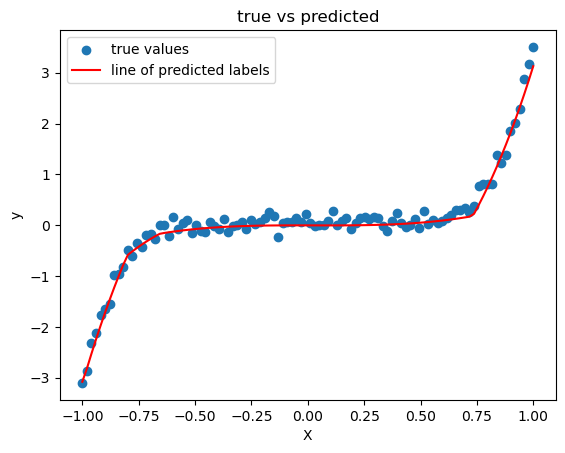

In [29]:
plt.scatter(x=X[:, 1], y=y, label='true values')
plt.plot(X[:, 1], y_pred_full, c='red', label='line of predicted labels')
plt.title('data plot')
plt.xlabel('X')
plt.ylabel('y')
plt.title('true vs predicted')
plt.legend()

У результаті ми отримали майже найкращі значення метрик і лінію яка ідеально (як могла звичайна лінія) пристосувалася до данних

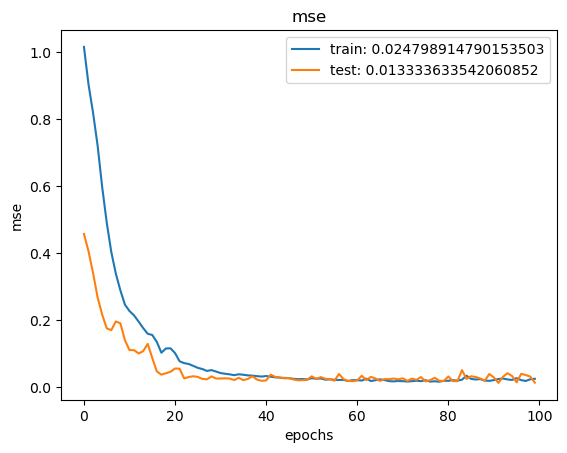

In [30]:
plt.plot(history.history['loss'], label=f"train: {history.history['loss'][-1]}")
plt.plot(history.history['val_loss'], label=f"test: {history.history['val_loss'][-1]}")
plt.xlabel("epochs")
plt.ylabel("mse")
plt.title('mse')
plt.legend()
plt.show()

Значення нашої функції втрат стабільно йшло у низ